In [75]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from Common import NeuralNet
import time
torch.manual_seed(128)


In [76]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from Common import NeuralNet
import time

class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        # extrema of the solution domain (t,x) in [0.0.1]x[-1,1]
        self.domain_extrema = torch.tensor([[0, 0.6], # time dimension
                                            [-1, 1]]) # space dimension
        # number of space dimensions
        self.space_dimensions = 1

        # parameter to balance role of data and PDE
        self.lambda_u = 10

        # F dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1, n_hidden_layers=4, neurons=20, regularization_param=0.,regularization_exp=2.,retrain_seed=42)

        # sobol sequences generator
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    # function to linearly transform a tensor whose values are between 0 and 1
    # to a tensor whose values are between the domain extrema

    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:,0]) + self.domain_extrema[:,0]

    # initial condition to solve the heat equation u0(x) = - sin(pi x)
    def initial_conditions(self, x):
            return -torch.sin(np.pi * x)

    # exact solution for the heat equation ut = u_xx with the IC above
    def exact_solution(self, inputs):
        t = inputs[:,0]
        x = inputs[:,1]

        u = -torch.exp(-np.pi**2*t) * torch.sin(np.pi * x)
        return u


    # function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0,0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:,0] = torch.full(input_tb[:,0].shape, t0)
        output_tb = self.initial_conditions(input_tb[:,1]).reshape(-1,1)

        return input_tb, output_tb
        # output is reshaped, so is an scaler here

    # function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1,0]
        xL = self.domain_extrema[1,1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb) # returns the copy of input, function is differentiable so gradient flows back to input
        input_sb_0[:,1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:,1] = torch.full(input_sb_L[:,1].shape, xL)

        output_sb_0 = torch.zeros((input_sb.shape[0],1))
        output_sb_L = torch.zeros((input_sb.shape[0], 1))
        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)


    # function returning the input-output tensor required to make the training set S_int corresponding to the interior domain where PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()
        input_tb, output_tb = self.add_temporal_boundary_points()
        input_int, output_int = self.add_interior_points()

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    # function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_conditions(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    # function to compute the term required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        u_pred_sb = self.approximate_solution(input_sb)
        return u_pred_sb

    # function to compute the pde residual
    def compute_pde_residual(self, input_int):
        input_int = input_int.clone().detach().requires_grad_(True)
        u = self.approximate_solution(input_int)

        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        grad_u_t = grad_u[:, 0]
        grad_u_x = grad_u[:, 1]
        grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:,1]

        stochastic_term = torch.randn_like(grad_u_xx) * 0.1

        residual = grad_u_t - grad_u_xx - stochastic_term
        return residual.reshape(-1,)


    # function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss, and interior loss
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, u_train_int, verbose=True):
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_conditions(inp_train_tb)

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])

        r_int = self.compute_pde_residual(inp_train_int)
        r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)

        loss_u = loss_sb + loss_tb
        
        total = self.lambda_u * loss_u + loss_int

        loss = torch.log10(total) # Using 'total' which is already computed

        if verbose:
            # "PDE Loss" (loss_int) and "Function Loss" (loss_u) labels
            print("Total loss: ", round(loss.item(), 4), " | PDE Loss: ", round(torch.log10(loss_int).item(), 4), " | Function Loss: ", round(torch.log10(loss_u).item(), 4))

        return total

    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # loop over epochs
        for epoch in range(num_epochs):
            if verbose:
                print("##########", epoch, "##########")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, u_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss', history[-1])

        return history


    def plotting(self):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)

        output = self.approximate_solution(inputs).reshape(-1,)
        exact_output = self.exact_solution(inputs).reshape(-1,)

        fig, axs = plt.subplots(1, 2, figsize=(16,8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=exact_output.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t") 

        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")

        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Exact Solution")
        axs[1].set_title("Approximate Solution")

        plt.show()
        err = (torch.mean((output - exact_output) ** 2) / torch.mean(exact_output ** 2)) **0.5 * 100
        print("L2 Relative Error Norm: ", err.item(), "%")

In [77]:
# solve the heat equation
n_int = 256
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

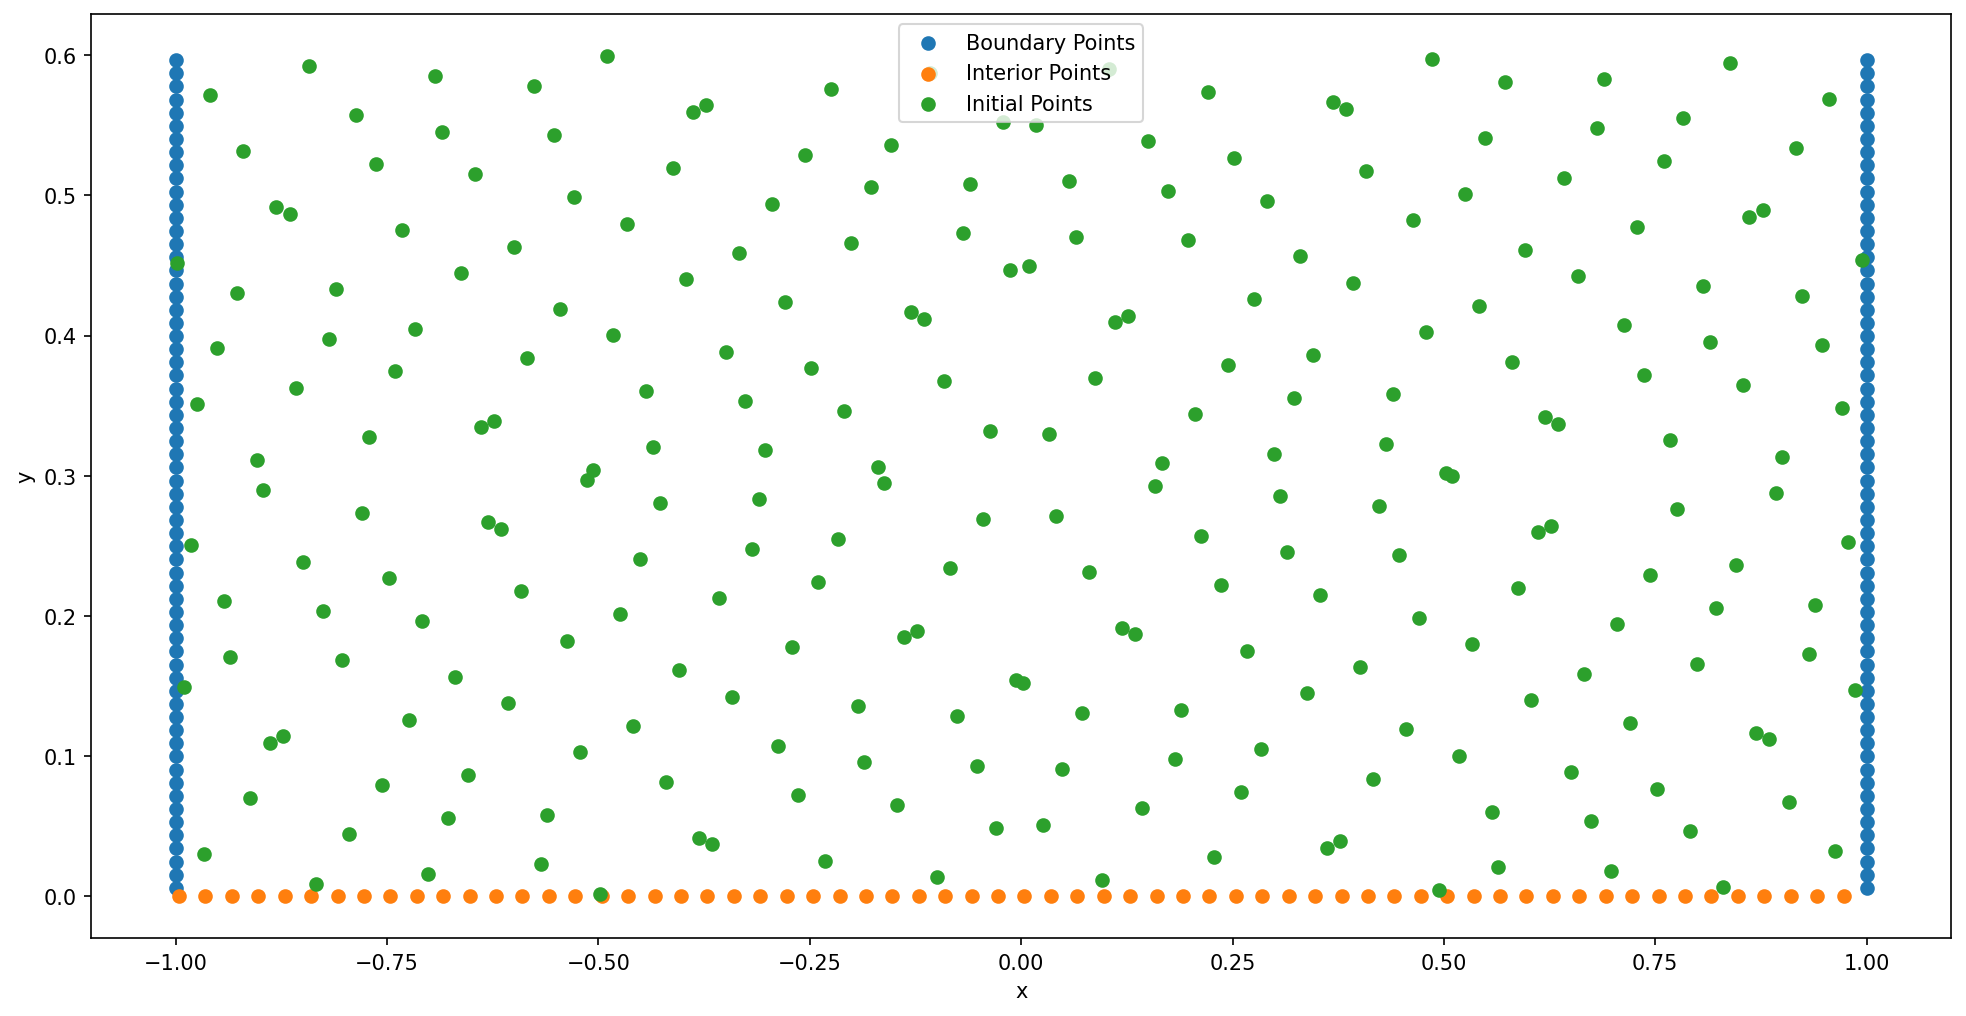

In [78]:
# plot the training curve
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(16,8), dpi=150)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Initial Points")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [79]:
n_epochs = 10000
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr = float(0.5),
                              max_iter = 50000,
                              max_eval = 50000,
                              history_size = 150,
                              line_search_fn = "strong_wolfe",
                              tolerance_change = 1.0*np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr = float(0.001))


########## 0 ##########
Total loss:  1.5614  | PDE Loss:  1.2073  | Function Loss:  0.3077
########## 1 ##########
Total loss:  1.4884  | PDE Loss:  1.1501  | Function Loss:  0.2218
########## 2 ##########
Total loss:  1.4158  | PDE Loss:  1.0904  | Function Loss:  0.1377
########## 3 ##########
Total loss:  1.3433  | PDE Loss:  1.0229  | Function Loss:  0.0608
########## 4 ##########
Total loss:  1.2735  | PDE Loss:  0.9465  | Function Loss:  -0.003
########## 5 ##########
Total loss:  1.2134  | PDE Loss:  0.8709  | Function Loss:  -0.0498
########## 6 ##########
Total loss:  1.1603  | PDE Loss:  0.7897  | Function Loss:  -0.0808
########## 7 ##########
Total loss:  1.1139  | PDE Loss:  0.7055  | Function Loss:  -0.1011
########## 8 ##########
Total loss:  1.0714  | PDE Loss:  0.6184  | Function Loss:  -0.1172
########## 9 ##########
Total loss:  1.0251  | PDE Loss:  0.5131  | Function Loss:  -0.1345
########## 10 ##########
Total loss:  0.9836  | PDE Loss:  0.424  | Function Loss:  -

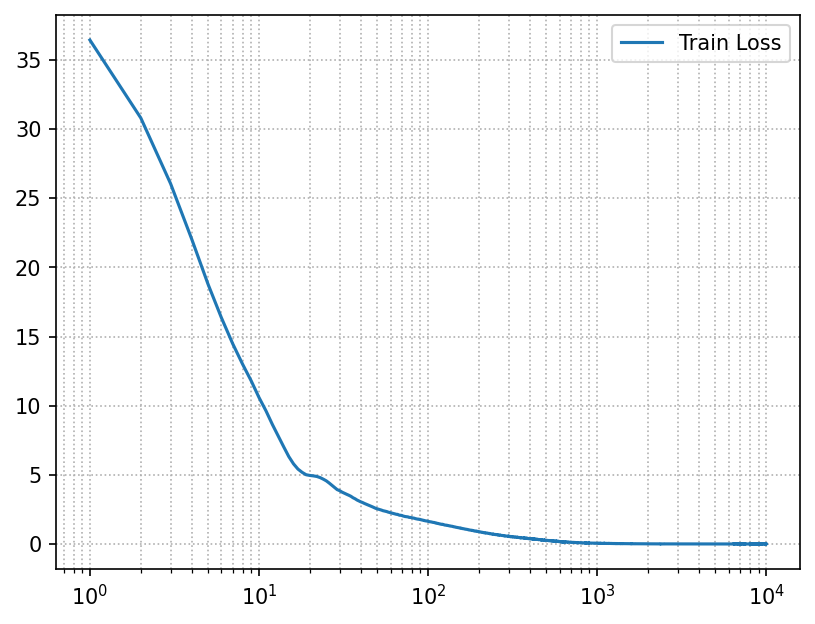

In [80]:
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_ADAM,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

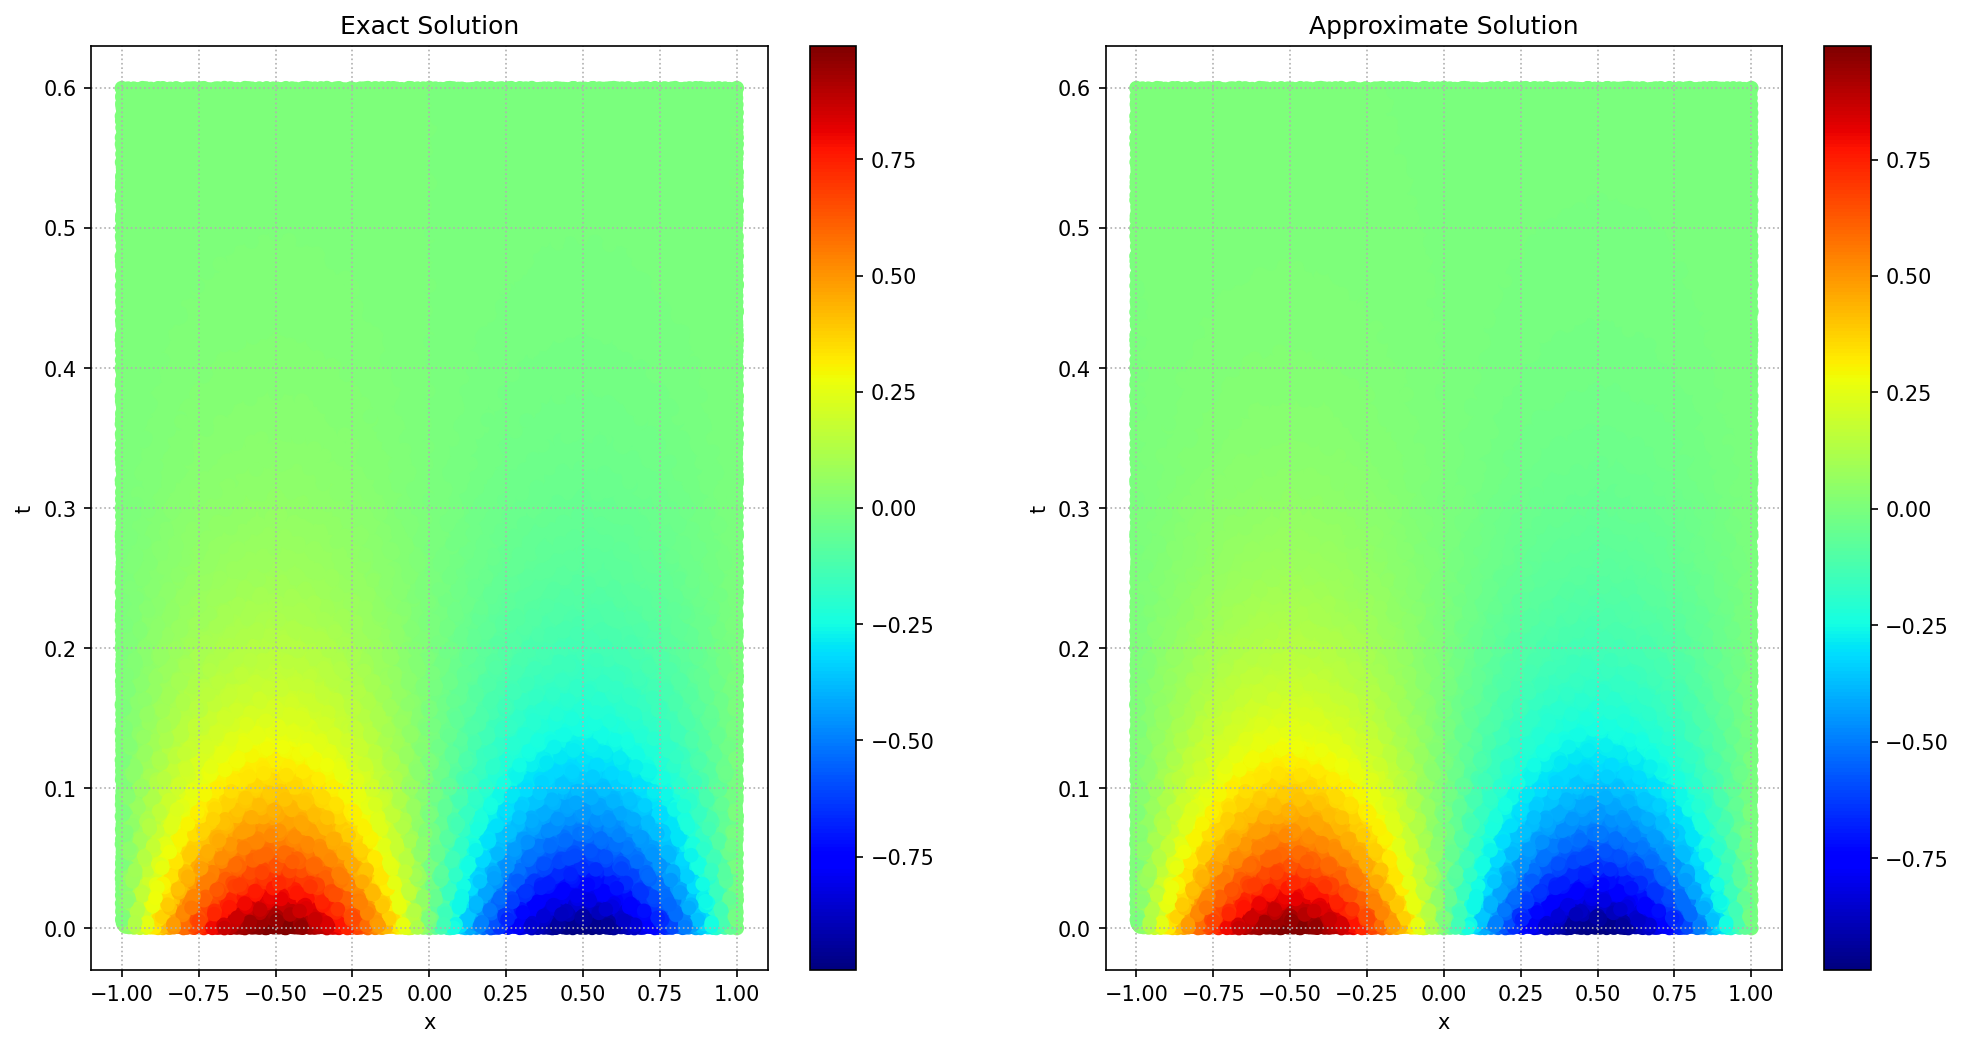

L2 Relative Error Norm:  0.843569278717041 %


In [81]:
pinn.plotting()